In [1]:
# Time each cell
%load_ext autotime

In [2]:
import os

from matplotlib import pyplot as plt
%matplotlib inline

import h5py
import pandas as pd
from glob import glob

from IPython.display import Image, display

import numpy as np
from astropy.io import fits
from astropy.nddata.utils import Cutout2D, PartialOverlapError, NoOverlapError
from astropy.stats import sigma_clipped_stats
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.stats import sigma_clipped_stats, sigma_clip
from astropy.time import Time
from astropy.utils.console import ProgressBar

from matplotlib.ticker import FormatStrFormatter
from copy import copy

from piaa.utils import helpers
from piaa.utils import images as img_utils
from pong.utils import metadb
from piaa import exoplanets
from piaa.observation import Observation
from piaa.utils import pipeline
from pocs.utils.images import fits as fits_utils

palette = copy(plt.cm.inferno)
palette.set_over('w', 1.0)
palette.set_under('k', 1.0)
palette.set_bad('g', 1.0)

/home/wtylergee/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


time: 2.69 s


In [3]:
os.environ['PGPASSWORD'] = 'pan0pt3&-t3ss'
data_dir = '/var/panoptes/images/fields'

time: 1.38 ms


In [4]:
sequences = !ls /var/panoptes/psc/*.hdf5 | cut -d '/' -f 5 | cut -d '.' -f 1
sequences

['PAN001_Wasp80_14d3bd_20180609T095151']

time: 36.6 ms


In [4]:
stamps_fn = '/var/panoptes/psc/PAN012_358d0f_20180822T035809.hdf5'

time: 1.02 ms


In [5]:
sequence = sequences[-1]
stamps_fn = '/var/panoptes/psc/{}.hdf5'.format(sequence)
stamps_fn

'/var/panoptes/psc/PAN001_Wasp80_14d3bd_20180609T095151.hdf5'

time: 4.4 ms


In [5]:
stamps = h5py.File(stamps_fn)

time: 2.62 ms


In [6]:
len(stamps)

401

time: 7.88 ms


In [40]:
picid = str(helpers.get_star_info(twomass_id='20004297+2242342')[0]) # HD 189733
picid

'256364937'

time: 334 ms


In [10]:
# picid = '243921117' # Wasp 80
# picid = '256364928'
# picid = '243952829'
# picid = '248311256'
# picid = '116264089' # Tres-3

time: 1.03 ms


In [11]:
# Get a random star
picid = list(stamps.keys())[np.random.randint(0, len(stamps))]

time: 2.17 ms


In [42]:
picid in stamps

False

time: 3.56 ms


In [22]:
num_refs = 100
camera_bias = 2048
stamp_size = (14, 14)

time: 1.17 ms


In [26]:
image_times = [Time(t0, format='mjd').to_datetime() for t0 in stamps.attrs['image_times']]

time: 36 ms


In [28]:
import h5py
from glob import glob
from tqdm import tqdm
from piaa.utils import pipeline

aperture_size = 8

for i, picid in tqdm(enumerate(list(stamps.keys()))):
    if 'similar_stars' in stamps[picid]:
        continue

    diff = list()
#     flags = stamps[picid].attrs['flags']

#     if int(flags):
#         continue

#     if float(stamps[picid].attrs['vmag']) > 13:
#         continue

    vary_series = pipeline.find_similar_stars(picid, stamps)

    # Store in stamps file
    stamps[picid]['similar_stars'] = vary_series[:200]
    stamps.flush()

0it [00:00, ?it/s]
Finding similar:  93%|█████████▎| 371/401 [00:01<00:00, 276.35it/s]
1it [00:01,  1.45s/it]
Finding similar:  98%|█████████▊| 392/401 [00:01<00:00, 320.89it/s]
2it [00:02,  1.36s/it]
Finding similar:  99%|█████████▉| 396/401 [00:01<00:00, 323.19it/s]
3it [00:03,  1.33s/it]
Finding similar:  99%|█████████▉| 396/401 [00:01<00:00, 324.61it/s]
4it [00:05,  1.31s/it]
Finding similar:  98%|█████████▊| 392/401 [00:01<00:00, 319.06it/s]
5it [00:06,  1.30s/it]
Finding similar:  99%|█████████▉| 397/401 [00:01<00:00, 323.94it/s]
6it [00:07,  1.30s/it]
Finding similar:  98%|█████████▊| 394/401 [00:01<00:00, 321.88it/s]
7it [00:09,  1.29s/it]
Finding similar: 100%|██████████| 401/401 [00:01<00:00, 327.34it/s]
8it [00:10,  1.29s/it]
Finding similar:  93%|█████████▎| 372/401 [00:01<00:00, 331.41it/s]
9it [00:11,  1.28s/it]
Finding similar: 100%|██████████| 401/401 [00:01<00:00, 327.62it/s]
10it [00:12,  1.28s/it]
Finding similar:  99%|█████████▉| 397/401 [00:01<00:00, 321.84it/s]
11

time: 8min 31s


In [17]:
aperture_size = 8

with ProgressBar(len(stamps), ipython_widget=True) as bar:
    for i, picid in enumerate(list(stamps.keys())):
        diff = list()
        flags = stamps[picid].attrs['flags']

        if int(flags):
            continue

        if float(stamps[picid].attrs['vmag']) > 13:
            continue

        vary_series = pipeline.find_similar_stars(
            picid, 
            stamps,
            out_fn='/var/panoptes/psc/similar_{}_{}.csv'.format(sequence.replace('/','_'), picid)
        )

        stamp_collection = np.array([pipeline.get_psc(str(idx), stamps) - camera_bias 
                                   for idx in vary_series.index[:num_refs]])
        
        num_frames = stamp_collection.shape[1]
        target_psc = stamp_collection[0].reshape(num_frames, -1)

        normalized_collection = np.array([pipeline.normalize(s) for s in stamp_collection])

        coeffs = pipeline.get_ideal_full_coeffs(normalized_collection)
        
        ideal_psc = pipeline.get_ideal_full_psc(
            stamp_collection, 
            coeffs[0]
        ).reshape(num_frames, -1)
        
        stamp_side = int(np.sqrt(target_psc.shape[1]))

        try:
            rgb_stamp_masks = helpers.get_rgb_masks(
                target_psc[0].reshape(stamp_side, stamp_side), 
                force_new=False,
                separate_green=True
            )
        except ValueError:
            continue
                
        for frame_idx, obstime in zip(range(num_frames), image_times):
            t0 = target_psc[frame_idx].reshape(stamp_side, stamp_side)
            i0 = ideal_psc[frame_idx].reshape(stamp_side, stamp_side)

#             star_pos_x = np.array(stamps[picid]['original_position'])[frame_idx][0]
#             star_pos_y = np.array(stamps[picid]['original_position'])[frame_idx][1]

            try:
                y_pos, x_pos = np.argwhere(t0 == t0.max())[0]
                aperture_position = (x_pos, y_pos)
            except IndexError:
#                 print("No star position: ", frame_idx, slice0, star_pos_x, star_pos_y)
                continue

            color_flux = dict()
            for color, mask in zip('rgcb', rgb_stamp_masks):

                t1 = np.ma.array(t0, mask=~mask)
                i1 = np.ma.array(i0, mask=~mask)

                try:
                    t2 = Cutout2D(t1, aperture_position, aperture_size, mode='strict')
                    i2 = Cutout2D(i1, aperture_position, aperture_size, mode='strict')
                except (PartialOverlapError, NoOverlapError) as e:
#                     print(aperture_position, e)
                    continue
                except Exception as e:
#                     print(e)
                    continue

                diff.append({
#                     'picid': picid,                
                    'color': color,
                    'target': t2.data.sum(),
                    'reference': int(i2.data.sum()),
                    'time': obstime
                })
                
        try:
            lc = pd.DataFrame(diff).set_index(['time'])
            lc1 = lc.groupby('color').mean()
            normalized_target = lc1.target / lc1.target.mean()
            normalized_reference = lc1.reference / lc1.reference.mean()
            lc['norm_target'] = normalized_target
            lc['norm_reference'] = normalized_reference
            lc['rel_flux'] = normalized_target / normalized_reference

            csv_file = '/var/panoptes/images/lc/{}_{}_lc.csv'.format(
                sequence.replace('/', '_'), 
                picid
            )
#             print("Writing csv to {}".format(csv_file))
            lc.to_csv(csv_file)
        except Exception as e:
            print("Problem creating CSV file: {}".format(e))        
            
        bar.update(i)

FloatProgress(value=0.0)

Problem creating CSV file: 'time'
Problem creating CSV file: 'time'
Problem creating CSV file: 'time'
Problem creating CSV file: 'time'
Problem creating CSV file: 'time'


FloatProgress(value=0.0)

FloatProgress(value=0.0)

FloatProgress(value=0.0)

FloatProgress(value=0.0)

FloatProgress(value=0.0)

FloatProgress(value=0.0)

FloatProgress(value=0.0)

FloatProgress(value=0.0)

FloatProgress(value=0.0)

FloatProgress(value=0.0)

FloatProgress(value=0.0)

FloatProgress(value=0.0)

FloatProgress(value=0.0)

KeyboardInterrupt: 

time: 29min 1s


In [ ]:
42

In [ ]:
lc = pd.read_csv('/var/panoptes/images/lc/{}_diff.csv'.format(sequence.replace('/', '_'))).set_index(['picid', 'obstime'])

In [54]:
lc.head()

color  reference  target  rel_flux
picid      time                                                  
1410183115 2018-06-09 09:56:59     r        428     442  1.032710
           2018-06-09 09:56:59     g        836     867  1.037081
           2018-06-09 09:56:59     c        824     867  1.052184
           2018-06-09 09:56:59     b        432     427  0.988426
           2018-06-09 10:00:02     r        435     456  1.048276

time: 13.3 ms


time: 4.24 ms


In [23]:
foo = lc.groupby(by=['picid', 'color']).describe()

time: 171 ms


In [57]:
foo.to_csv('/var/panoptes/g_stats_{}_desc.csv'.format(sequence.replace('/', '_')))

time: 8.58 ms


In [27]:
picid_list = lc.picid.unique()

exp_time = 120

stats = list()
for picid in ProgressBar(picid_list, ipython_widget=True):
    rows = lc.picid == picid
    color = lc.color == 'g'

    l0 = lc[rows & color]
    
    count_mean, count_median, count_std = sigma_clipped_stats(l0.target)
    
    mag = -2.5 * np.log10(l0.target / exp_time)

    mag_mean, mag_median, mag_std = sigma_clipped_stats(mag)
    
#     std = (l0.value - l0.value.mean()).std()
#     avg_std = (std / l0.value).mean()

    # Get the vmag
    vmag = stamps[str(picid)].attrs['vmag']
    
    stats.append([vmag, count_mean, count_median, count_std, mag_mean, mag_median, mag_std])

FloatProgress(value=0.0)


time: 127 ms


In [28]:
g_stats = pd.DataFrame(stats, 
                       columns=[
                           'vmag',
                           'count_mean', 
                           'count_median', 
                           'count_std', 
                           'mag_mean', 
                           'mag_median', 
                           'mag_std'
                       ], index=picid_list)

time: 4.11 ms


In [29]:
g_stats.to_csv('/var/panoptes/g_stats_{}.csv'.format(sequence))

time: 4.17 ms


In [30]:
plt.style.use('bmh')

time: 1.78 ms


In [31]:
mags = g_stats.vmag
stds = g_stats.mag_std

time: 1.53 ms


Text(0,0.5,'Standard dev. (mag.)')

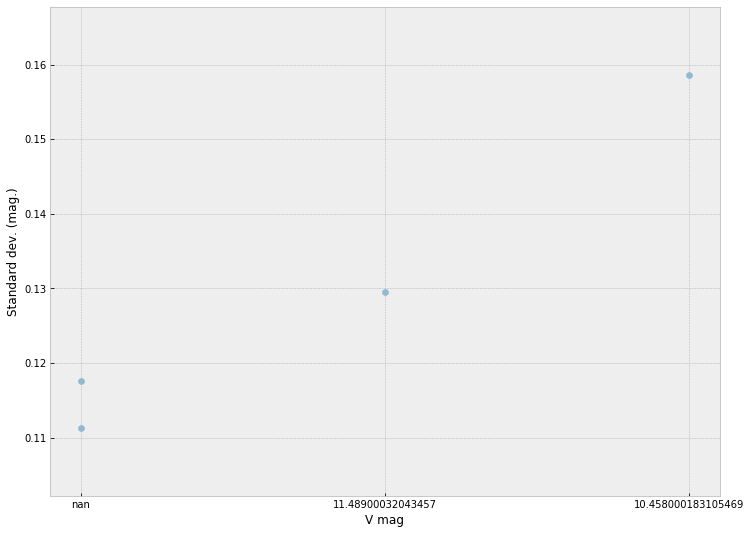

time: 314 ms


In [34]:
plt.figure(figsize=(12,9))
plt.scatter(mags, stds, alpha=0.5)
# plt.xlim([6,14])
# plt.ylim([0, .2])
plt.xlabel('V mag')
plt.ylabel('Standard dev. (mag.)')

In [69]:
lc.groupby(by='picid').vmag.hist(bins=np.arange(6,17))

AttributeError: 'DataFrameGroupBy' object has no attribute 'vmag'

time: 41.4 ms


In [70]:
lc.vmag.hist(bins=np.arange(6,17))

AttributeError: 'DataFrame' object has no attribute 'vmag'

time: 21.4 ms
